In [1]:
import pyproj
import pygmt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import ensaio
import verde as vd

In [2]:
def plot_geographic_scatter(longitude, latitude, data, title=None, style="c0.02c"):
    """Plot geographic data using mercator projection"""
    fig = pygmt.Figure()
    fig.basemap(
        region=[
            longitude.min(),
            longitude.max(),
            latitude.min(),
            latitude.max(),
        ],
        projection="M15c",
        frame=True,
    )
    pygmt.makecpt(cmap="viridis", series=[data.min(), data.max()])
    fig.plot(
        x=longitude, y=latitude, color=data, cmap=True, style=style
    )
    frame = 'af'
    if title is not None:
        frame += f'+l"{title}"'
    fig.colorbar(frame=frame)
    fig.coast(land="#666666")
    fig.show()
    

## Download and load the data

In [3]:
fname = ensaio.fetch_caribbean_bathymetry(version=1)
fname

PosixPath('/home/santi/.cache/ensaio/v1/caribbean-bathymetry.csv.xz')

In [4]:
data = pd.read_csv(fname)
data

,survey_id,latitude,longitude,depth_m
0,FM0501,23.13070,-87.99680,75
1,FM0501,23.11940,-87.98640,75
2,FM0501,23.10810,-87.97610,73
3,FM0501,23.09670,-87.96580,73
4,FM0501,23.08540,-87.95540,73
...,...,...,...,...
1938090,EW0003,9.92284,-84.72557,20
1938091,EW0003,9.92282,-84.72565,20
1938092,EW0003,9.92283,-84.72570,20
1938093,EW0003,9.92284,-84.72574,21


/tmp/ipykernel_37334/2111858496.py:15: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


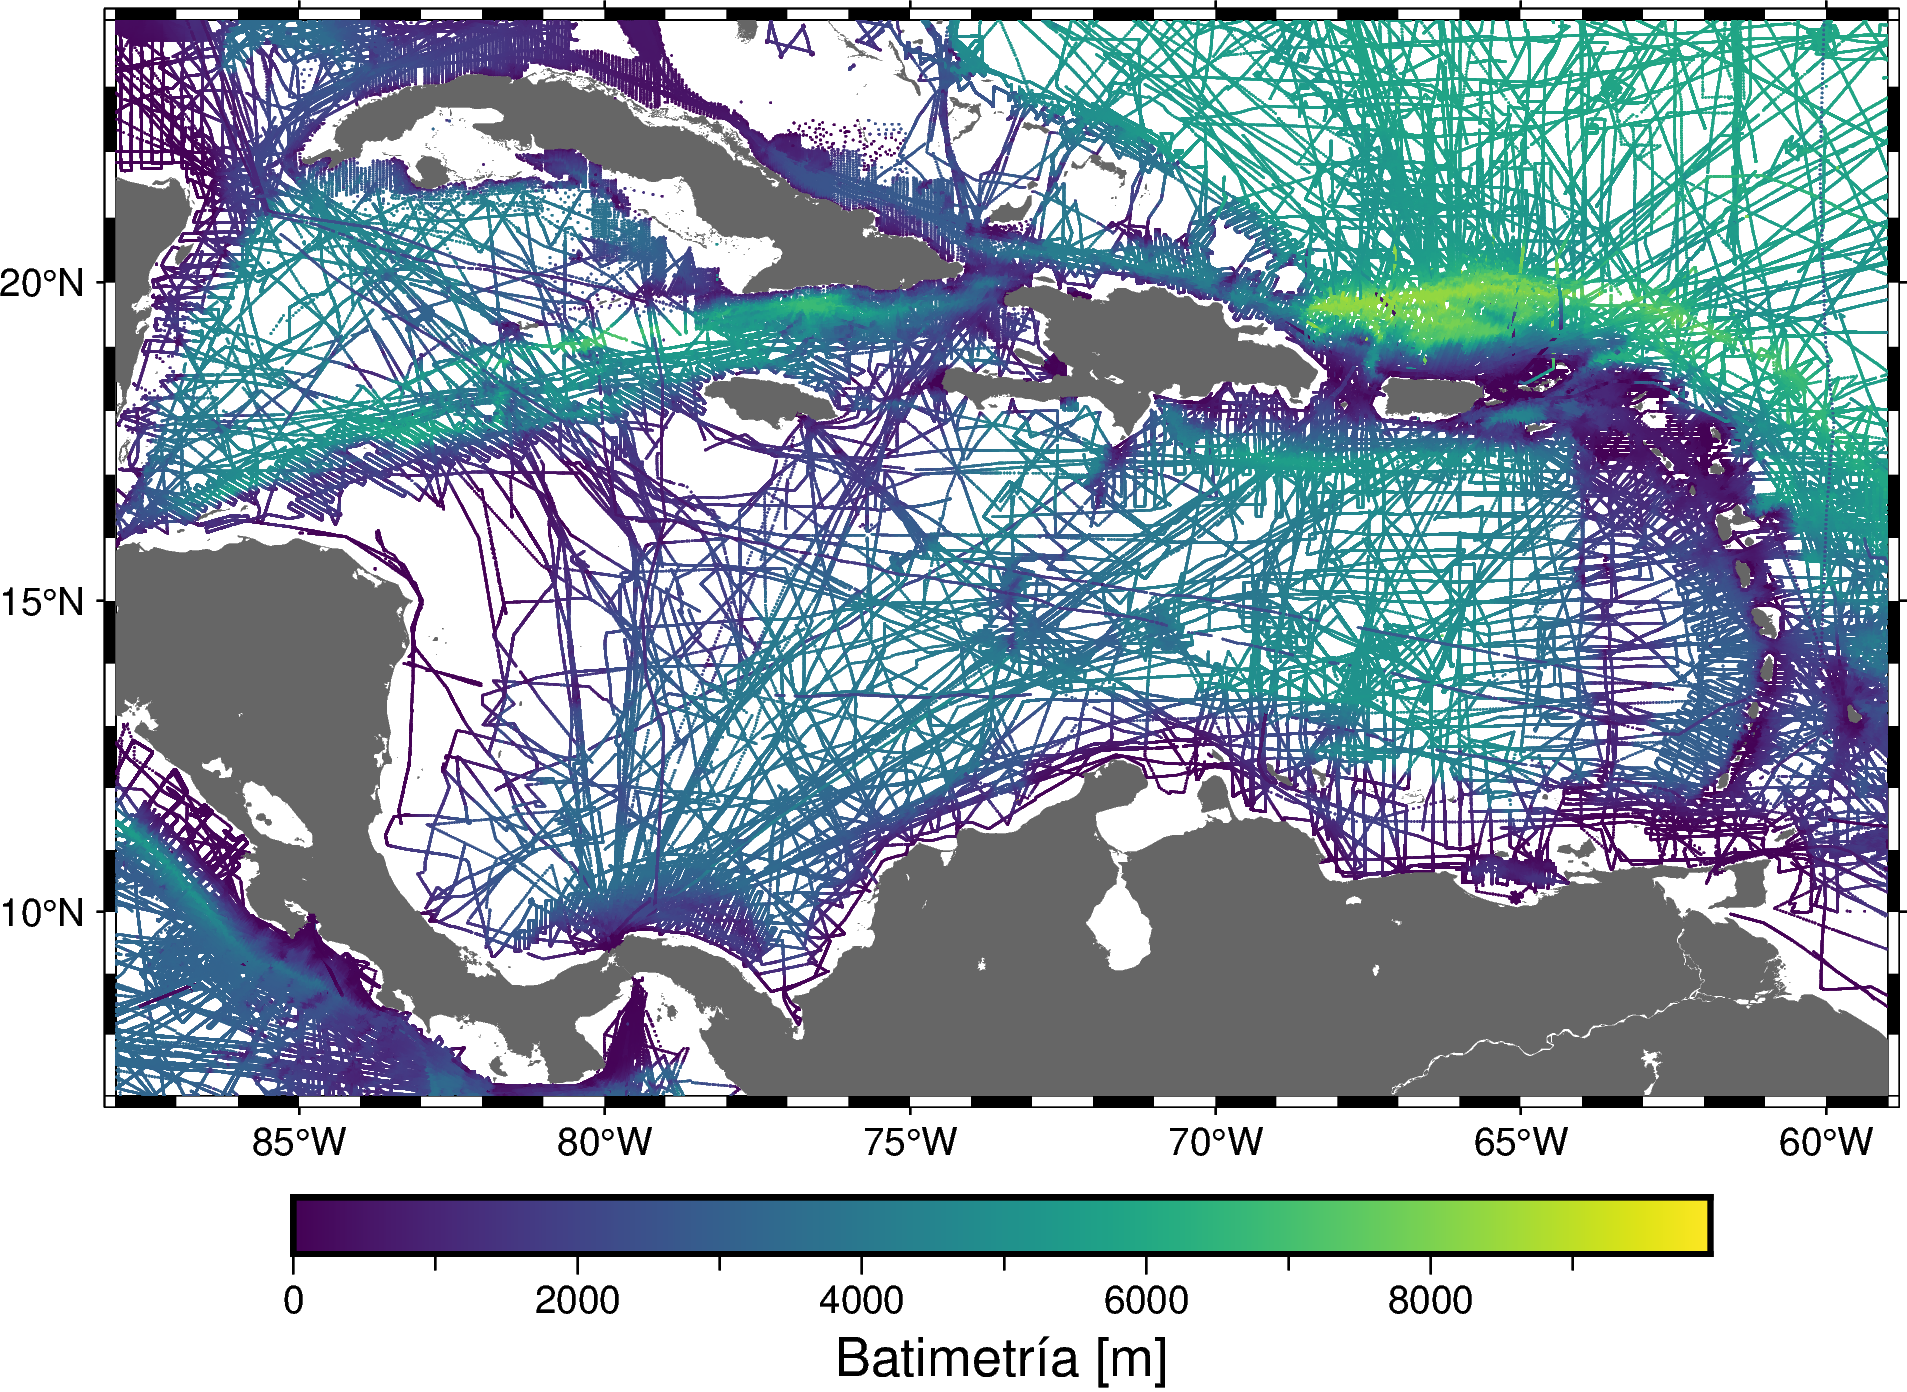

In [5]:
plot_geographic_scatter(
    data.longitude, data.latitude, data.depth_m, title="Batimetría [m]"
)

## Decimate the data

In [6]:
spacing = 20 / 60
reducer = vd.BlockReduce(reduction=np.median, spacing=spacing)

In [7]:
(longitude, latitude), bathymetry = reducer.filter(
    coordinates=(data.longitude, data.latitude),
    data=data.depth_m,
)

In [8]:
reduced_data = pd.DataFrame(
    {"longitude": longitude, "latitude": latitude, "depth_m": bathymetry}
)
reduced_data

,longitude,latitude,depth_m
0,-87.858010,7.222440,3286.0
1,-87.505905,7.113470,3246.0
2,-87.172770,7.226680,3242.0
3,-86.802175,7.070485,3047.0
4,-86.568100,7.129500,3006.0
...,...,...,...
3323,-60.472600,23.735400,5898.0
3324,-60.087700,23.748600,5924.0
3325,-59.912700,23.779000,5930.0
3326,-59.483700,23.765200,5932.0


/tmp/ipykernel_37334/2111858496.py:15: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(


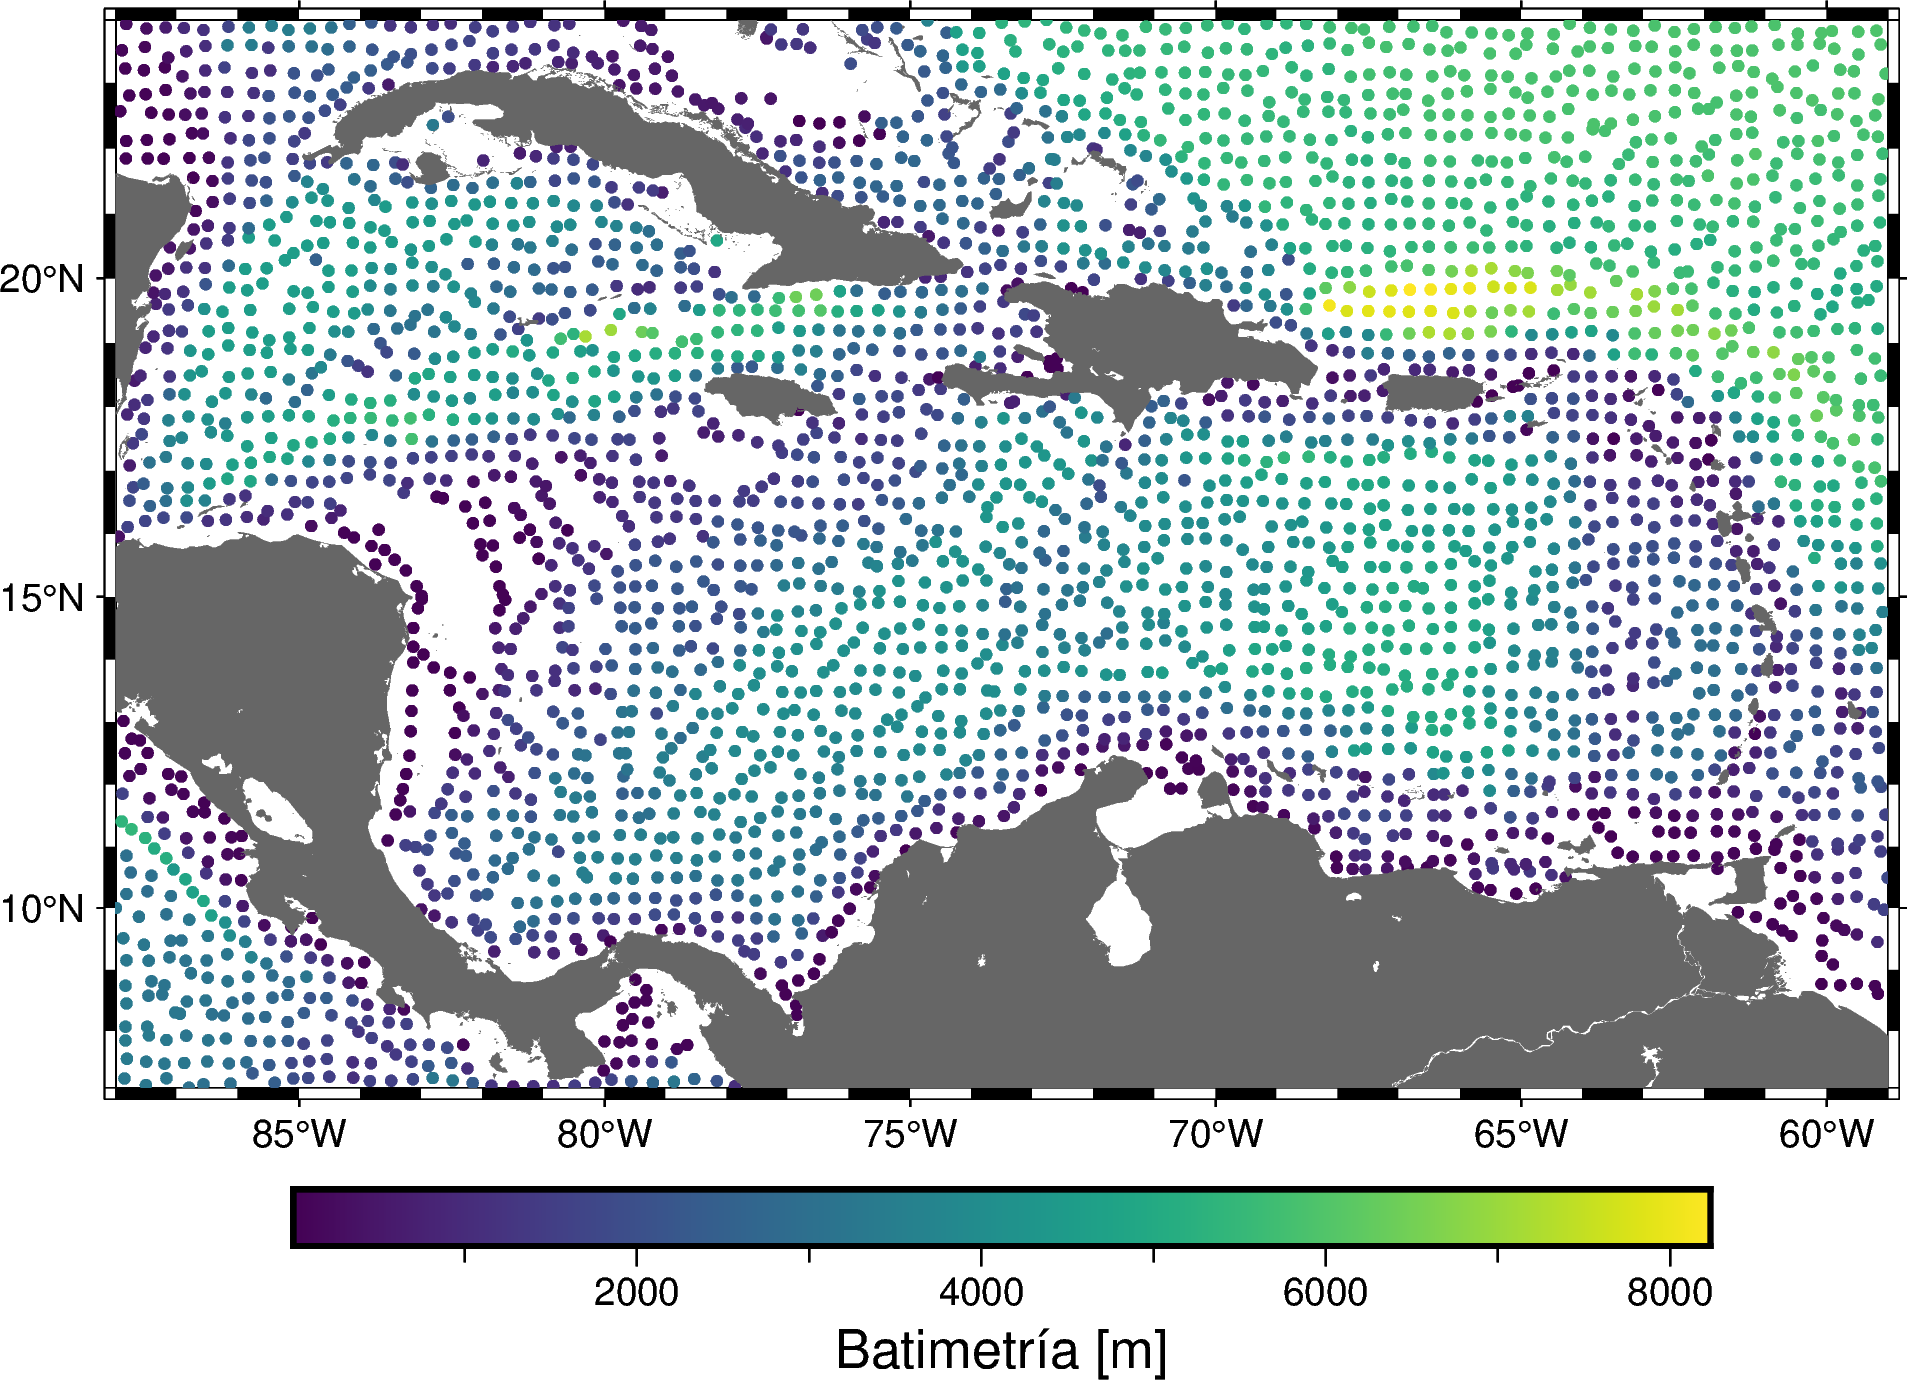

In [9]:
plot_geographic_scatter(
    reduced_data.longitude, reduced_data.latitude, reduced_data.depth_m, title="Batimetría [m]", style="c0.1c"
)

## Grillado

### Projectar los datos a coordenadas planas (cartesianas)

In [10]:
projection = pyproj.Proj(proj="merc", lat_ts=reduced_data.latitude.mean())
projection

<Other Coordinate Operation Transformer: merc>
Description: PROJ-based coordinate operation
Area of Use:
- undefined

In [11]:
easting, northing = projection(reduced_data.longitude.values, reduced_data.latitude.values)

In [12]:
reduced_data["easting"] = easting
reduced_data["northing"] = northing
reduced_data

,longitude,latitude,depth_m,easting,northing
0,-87.858010,7.222440,3286.0,-9.373916e+06,7.674942e+05
1,-87.505905,7.113470,3246.0,-9.336348e+06,7.558534e+05
2,-87.172770,7.226680,3242.0,-9.300805e+06,7.679472e+05
3,-86.802175,7.070485,3047.0,-9.261265e+06,7.512623e+05
4,-86.568100,7.129500,3006.0,-9.236290e+06,7.575657e+05
...,...,...,...,...,...
3323,-60.472600,23.735400,5898.0,-6.452059e+06,2.591649e+06
3324,-60.087700,23.748600,5924.0,-6.410992e+06,2.593178e+06
3325,-59.912700,23.779000,5930.0,-6.392321e+06,2.596703e+06
3326,-59.483700,23.765200,5932.0,-6.346549e+06,2.595103e+06


### Grillar los datos

In [13]:
spline = vd.Spline(damping=1e-7).fit(
    (reduced_data.easting, reduced_data.northing), 
    reduced_data.depth_m,
)
spline

Spline(damping=1e-07)

In [19]:
region = vd.get_region((reduced_data.longitude, reduced_data.latitude))
region

(-87.99834, -59.0034, 7.070485, 23.94275)

In [40]:
grid = spline.grid(region=region, spacing=spacing / 2, projection=projection, data_names="bathymetry", dims=("latitude", "longitude"))
grid

/home/santi/.mambaforge/envs/2023-fatiando-igeba/lib/python3.9/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


<xarray.Dataset>
Dimensions:     (latitude: 102, longitude: 175)
Coordinates:
  * longitude   (longitude) float64 -88.0 -87.83 -87.67 ... -59.34 -59.17 -59.0
  * latitude    (latitude) float64 7.07 7.238 7.405 7.572 ... 23.61 23.78 23.94
Data variables:
    bathymetry  (latitude, longitude) float64 3.336e+03 3.301e+03 ... 5.946e+03
Attributes:
    metadata:  Generated by Spline(damping=1e-07)

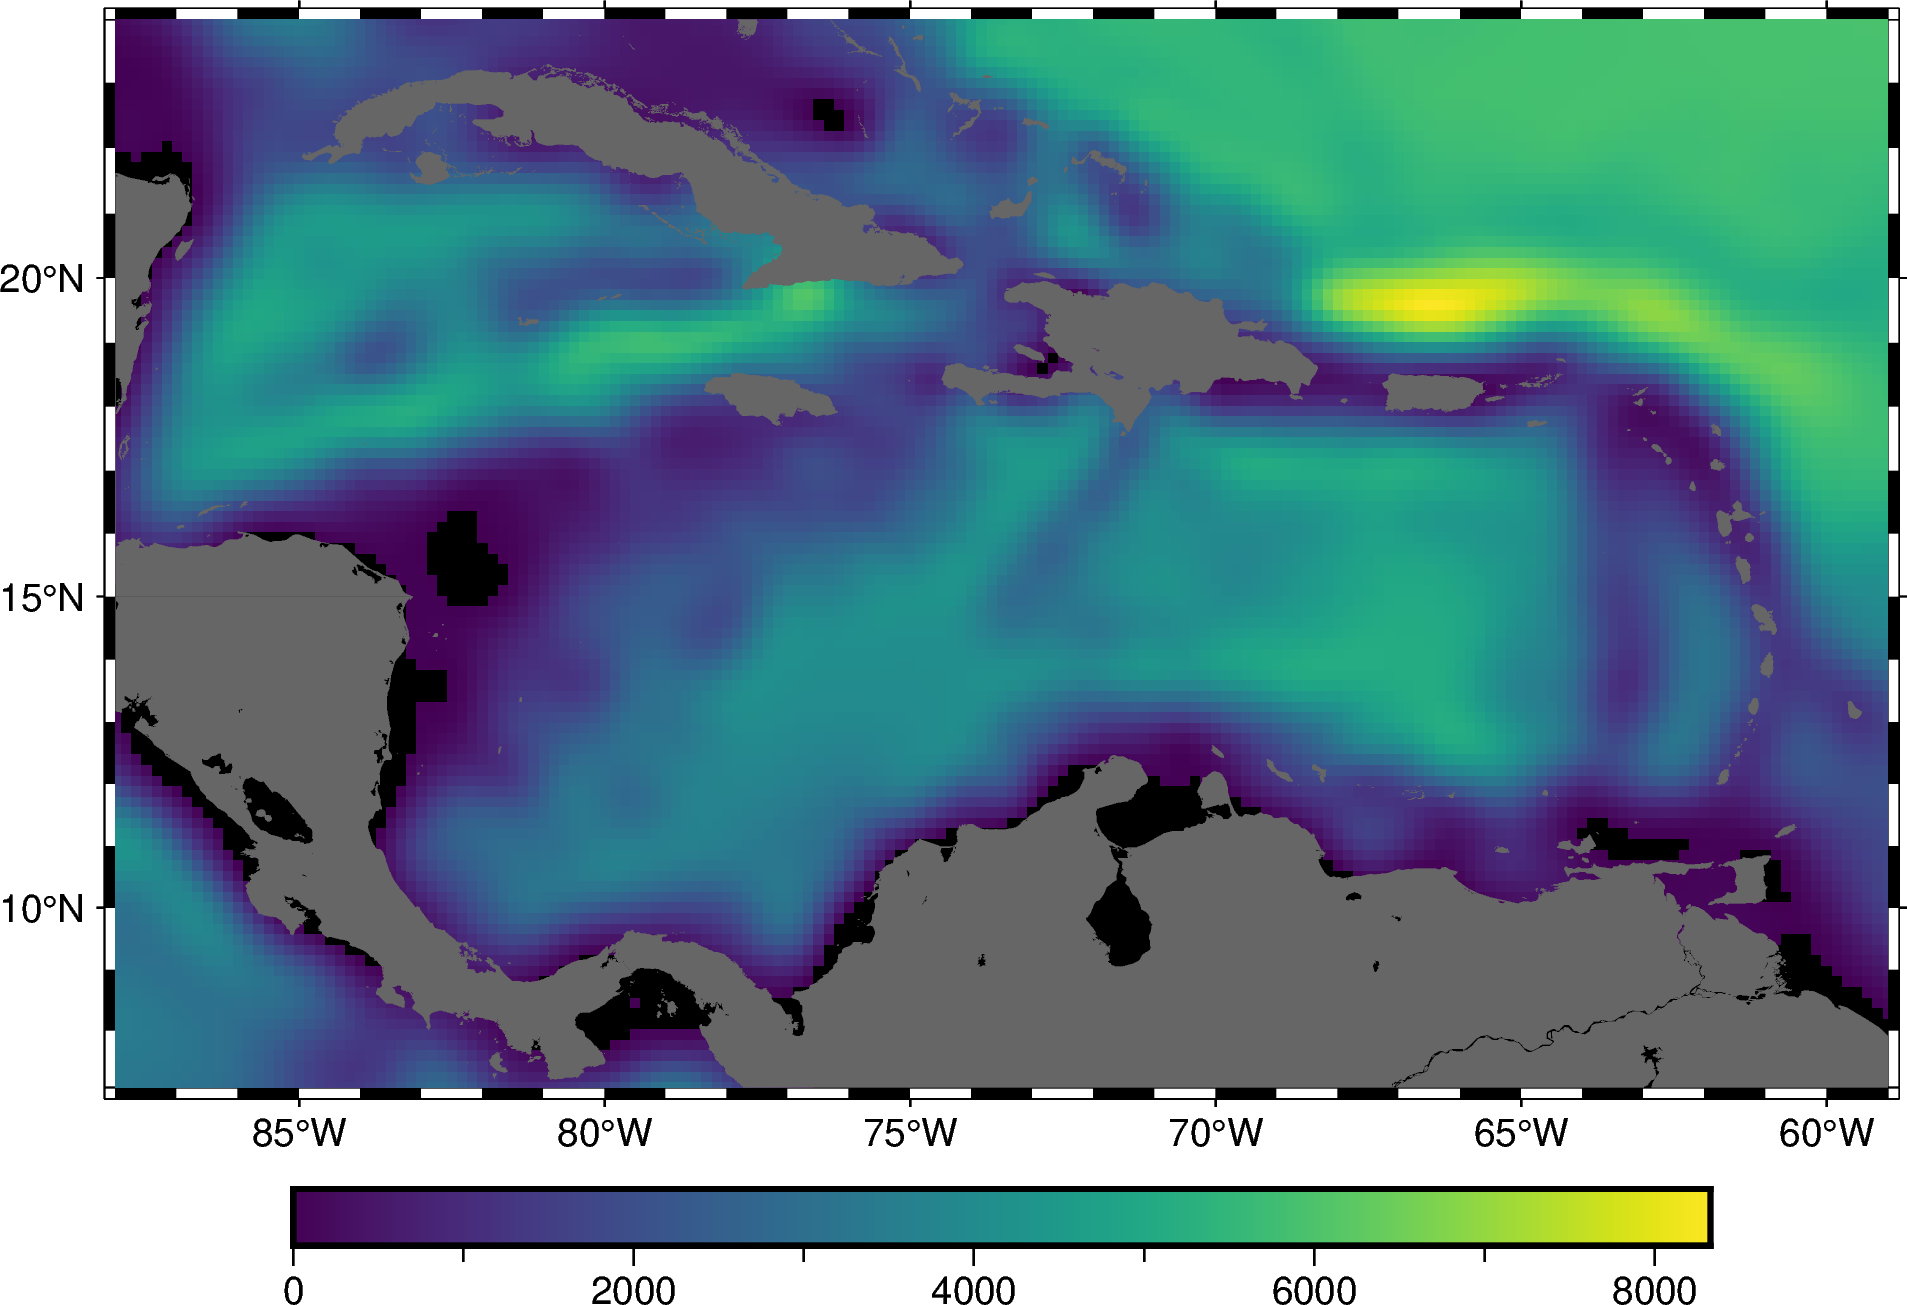

In [44]:
fig = pygmt.Figure()

fig.basemap(
    region=[
        grid.longitude.values.min(),
        grid.longitude.values.max(),
        grid.latitude.values.min(),
        grid.latitude.values.max(),
    ],
    projection="M15c",
    frame=True,
)

pygmt.makecpt(cmap="viridis", series=[0, grid.bathymetry.values.max()])
fig.grdimage(grid=grid.bathymetry, cmap=True)

frame = 'af'
fig.colorbar(frame=frame)
fig.coast(land="#666666")
fig.show()